### Import the required libraries

In [1]:
from casadi import *
from casadi.tools import *
import numpy as np
from scipy import optimize
import pickle
import os
import csv

### Funcions for finding the optimal trajectory

In [2]:
def penalty(x, k, mu, amp):
    """Generate the spatial cost (approximation of the Heaviside function)
    Args:
        x: scalar, list or array 
        k: scalar, steepness of the spatial penalty function 
        mu: scalar, beam location
        amp: scalar, height of the spatial penalty function
    Returns:
        p: scalar, list or array, value of the spatial cost for x 
    """  
    return(amp/(1+np.exp(1+k*(x-mu))))

def optimal_trajectory(cost, a, b, xb, xi, xf, tf, vtapis, tau_res, mass, ampxpenalty, kxpenalty, nk):
    """Compute the optimal trajectory
    Args:
        cost: string, cost type (defines the effort and spacial costs)  
        a: scalar, effort sensitivity 
        b: scalar, spacial sensitivity
        xb: scalar, beam location
        xi: scalar, initial position
        xf: scalar, final position
        tf: scalar, final time (entrance time)
        vtapis: scalar, treadmill speed
        tau_res: scalar, resistive force, tau
        mass: scalar, rat's weight (mass)
        ampxpenalty: scalar, height of the spatial penalty function
        kxpenalty: scalar, steepness of the spatial penalty function 
        nk: scalar, number of collocation points
    Returns:
        (x0_opt,x1_opt,tgrid,u_opt,tgrid_u,float(res["f"])): lists; optimal positions, optimal speeds
        time for postion and speed), optimal control, time for optimal control, final total cost. 

    """
    
    Ltread=0.9
    mu=0.1    # Control discretization
    kT=mu/1
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1],u)    
    rhs["x"] = vertcat(x[1],u - fabs(x[1]-vtapis)/tau_res)
        
    
    if cost=='speed_quadratic':
        
        rhs["L"] = a*mass*(x[1]-vtapis)**2 + b*(x[0]-Ltread)**2
    
    elif cost=='force_quadratic':   
        rhs["L"] = a*(mass*u)**2 + b*(x[0]-Ltread)**2  

    elif cost=='speed_heaviside':
        
        rhs["L"] = a*mass*(x[1]-vtapis)**2 + b*penalty(x=x[0],k=kxpenalty,mu=xb,amp=ampxpenalty)
    
    elif cost=='force_heaviside':   
        rhs["L"] = a*(mass*u)**2 + b*penalty(x=x[0],k=kxpenalty,mu=xb,amp=ampxpenalty)

    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -1.8 #-7.5
    u_max = 1.8 #7.5
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [xi,  vtapis-0.7,  0.0]
    xi_max = [xi,  vtapis,  inf]
    #xf_min = [xf,  vtapis-0.7, -inf]
    xf_min = [xf,  vtapis-0.4, -inf]    
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    #opts = {}
    #opts["expand"] = True
    #opts["ipopt.max_iter"] = 4
    opts = {'ipopt.print_level':0, 'print_time':0} # hide ipopt output  # opts = {}
    opts["expand"] = True


    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    #print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return x0_opt

### Load the required data 

In [3]:
import pickle5 as pickle
data_folder = './Data_for_fit/Before/'
file_to_open = data_folder + 'clean_max_pos_traj.pickle'
with open(file_to_open, 'rb') as handle:
    trajectories_before = pickle.load(handle)    
file_to_open = data_folder + 'clean_ET_max_pos.pickle'
with open(file_to_open, 'rb') as handle:
    tf_before = pickle.load(handle)  
    
data_folder = './Data_for_fit/Final/'
file_to_open = data_folder + 'clean_max_pos_traj.pickle'
with open(file_to_open, 'rb') as handle:
    trajectories_final = pickle.load(handle)
file_to_open = data_folder + 'clean_ET_max_pos.pickle'
with open(file_to_open, 'rb') as handle:
    tf_final = pickle.load(handle)    
    
file_to_open = data_folder + '_lesion_size_.p'   
with open(file_to_open, 'rb') as handle:
    lesion_size_final = pickle.load(handle)  

In [4]:
data_folder = './Data_for_fit/'
file_to_open = data_folder + 'AnimalList.txt'

selected_rats = []   
crimefile = open(file_to_open, 'r')
reader = csv.reader(crimefile)
rats_list = [row for row in reader]
for i_rat, aux in enumerate(rats_list):
    selected_rats.append(rats_list[i_rat][0][:])
#selected_rats[-1] = 'Rat221' 

In [5]:
dt = 0.04
shift_time = 1 

## Model fitting

In [6]:
results_folder = 'PickleResults/Fit'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [7]:
ampxpenalty = 10
kxpenalty = 1
xb = 0.1
vtapis = 0.1
tau_res = 1.8
mass = 1
shift_time = 1 # s 
b = 1
bounds = optimize.Bounds(0,100)

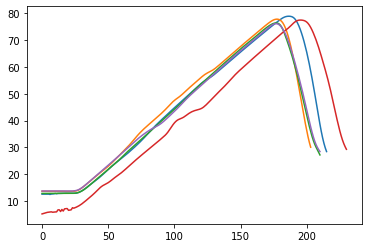

In [8]:
import matplotlib.pyplot as plt
for t in trajectories_before['Rat302']:
    plt.plot([i for i in range(0, len(t))], t)



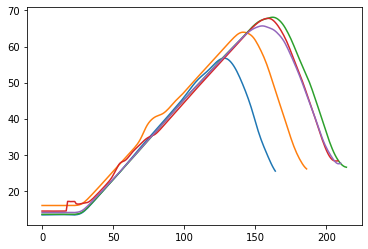

In [9]:
for t in trajectories_final['Rat302']:
    plt.plot([i for i in range(0, len(t))], t)
    

### Find the trajectory corresponding to the median max position (for each animal and for each session)

In [28]:
###########################################################
# Parameter fit- Before Lesion
ig_before = 1
a_fit_before_dict = dict()
xk_fit_before_dict = dict()
cost = 'speed_heaviside'
for rat in ['Rat302']:
#for rat in [selected_rats[2]]:
#for rat in selected_rats:    
    a_fit_list = []
    xk_fit_list = []
    
    for i_sess in range(len(trajectories_before[rat])):

        real_trajectory = trajectories_before[rat][i_sess][int(shift_time/dt):]*0.01
        xi = real_trajectory[0]
        xf = real_trajectory[-1]
        tf = tf_before[rat][i_sess]-shift_time
        nk = len(real_trajectory)-1

        def E(a,cost=cost,b=b,
                         xb=xb,xi=xi,xf=xf,tf=tf,
                         vtapis=vtapis,tau_res=tau_res, mass=mass,
                         ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk, 
                         real_trajectory=real_trajectory):

            xk = optimal_trajectory(cost=cost,a=a,b=b,
                                    xb=xb,xi=xi,xf=xf,tf=tf,
                                    vtapis=vtapis,tau_res=tau_res, mass=mass,
                                    ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk)    

            #return np.abs((np.max(xk)-np.max(real_trajectory)))
            return np.sum((xk-real_trajectory)**2) 
        
        res = optimize.minimize(E, x0=np.array([ig_before]), method='trust-constr', 
                                bounds=bounds, options={'xtol': 1e-1, 'disp': False})
        
        a_fit = res.x[0]
        xk_fit = optimal_trajectory(cost=cost,a=a_fit,b=b,
                                xb=xb,xi=xi,xf=xf,tf=tf,
                                vtapis=vtapis,tau_res=tau_res, mass=mass,
                                ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk)
        
        a_fit_list.append(a_fit)
        xk_fit_list.append(xk_fit)
    
    a_fit_before_dict[rat] = a_fit_list
    xk_fit_before_dict[rat] = xk_fit_list
    
with open(results_folder + '/xk_fit_bounded_beforeXXspeed.pickle', 'wb') as handle:
    pickle.dump(xk_fit_before_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)    

with open(results_folder + '/a_fit_bounded_beforeXXspeed.pickle', 'wb') as handle:
    pickle.dump(a_fit_before_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)  

##################################################################################################################
##################################################################################################################
###########################################################
# Parameter fit- After Lesion
ig_after = 5
a_fit_final_dict = dict()
xk_fit_final_dict = dict()

for rat in ['Rat302']:
#for rat in selected_rats:
#for rat in [selected_rats[2]]:
    a_fit_list = []
    xk_fit_list = []
    
    for i_sess in range(len(trajectories_final[rat])):

        real_trajectory = trajectories_final[rat][i_sess][int(shift_time/dt):]*0.01
        xi = real_trajectory[0]
        xf = real_trajectory[-1]
        tf = tf_final[rat][i_sess]-shift_time
        nk = len(real_trajectory)-1
        
        def E(a,cost=cost,b=b,
                         xb=xb,xi=xi,xf=xf,tf=tf,
                         vtapis=vtapis,tau_res=tau_res, mass=mass, 
                         ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk, 
                         real_trajectory=real_trajectory):

            xk = optimal_trajectory(cost=cost,a=a,b=b,
                                    xb=xb,xi=xi,xf=xf,tf=tf,
                                    vtapis=vtapis,tau_res=tau_res, mass=mass, 
                                    ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk)    

            #return np.abs((np.max(xk)-np.max(real_trajectory)))
            return np.sum((xk-real_trajectory)**2) 
        
        #res = optimize.minimize(E, x0=np.array([ig_after]), method='nelder-mead' ,
        #                        options={'xatol': 1e-1, 'disp': True}) 
        res = optimize.minimize(E, x0=np.array([ig_after]), method='trust-constr', 
                                bounds=bounds, options={'xtol': 1e-1, 'disp': True})        
        a_fit = res.x[0]
        xk_fit = optimal_trajectory(cost=cost,a=a_fit,b=b,
                                xb=xb,xi=xi,xf=xf,tf=tf,
                                vtapis=vtapis,tau_res=tau_res, mass=mass,
                                ampxpenalty=ampxpenalty,kxpenalty=kxpenalty,nk=nk)
        
        a_fit_list.append(a_fit)
        xk_fit_list.append(xk_fit)
    
    a_fit_final_dict[rat] = a_fit_list
    xk_fit_final_dict[rat] = xk_fit_list
    
with open(results_folder + '/xk_fit_bounded_finalXXspeed.pickle', 'wb') as handle:
    pickle.dump(xk_fit_final_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)    

with open(results_folder + '/a_fit_bounded_finalXXspeed.pickle', 'wb') as handle:
    pickle.dump(a_fit_final_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)     


`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 32, CG iterations: 15, optimality: 8.39e-09, constraint violation: 0.00e+00, execution time: 1.7e+01 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 22, CG iterations: 10, optimality: 6.98e-09, constraint violation: 0.00e+00, execution time: 1.5e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 50, CG iterations: 23, optimality: 2.69e-08, constraint violation: 0.00e+00, execution time: 4.2e+01 s.
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 14, CG iterations: 6, optimality: 4.74e-09, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 14, CG iterations: 6, optimality: 3.34e-09, constraint violation: 0.00e+00, execution time: 1e+01 s.


In [31]:
a_fit_final_dict

{'Rat302': [2.952468284181248,
  3.800644541443261,
  5.130927707113758,
  5.2440840463066465,
  5.711591730202074]}

### Compute delta alpha median and save

In [18]:
delta_a_median_bounded_dict = {rat: np.median(np.array(a_fit_final_dict[rat]))-
                       np.median(np.array(a_fit_before_dict[rat])) for rat in tuple(selected_rats)}

KeyError: 'Rat260'

In [ ]:
with open(results_folder + '/delta_a_boundedXXspeed.pickle', 'wb') as handle:
    pickle.dump(delta_a_median_bounded_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'delta_a_median_bounded_dict' is not defined

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same argument

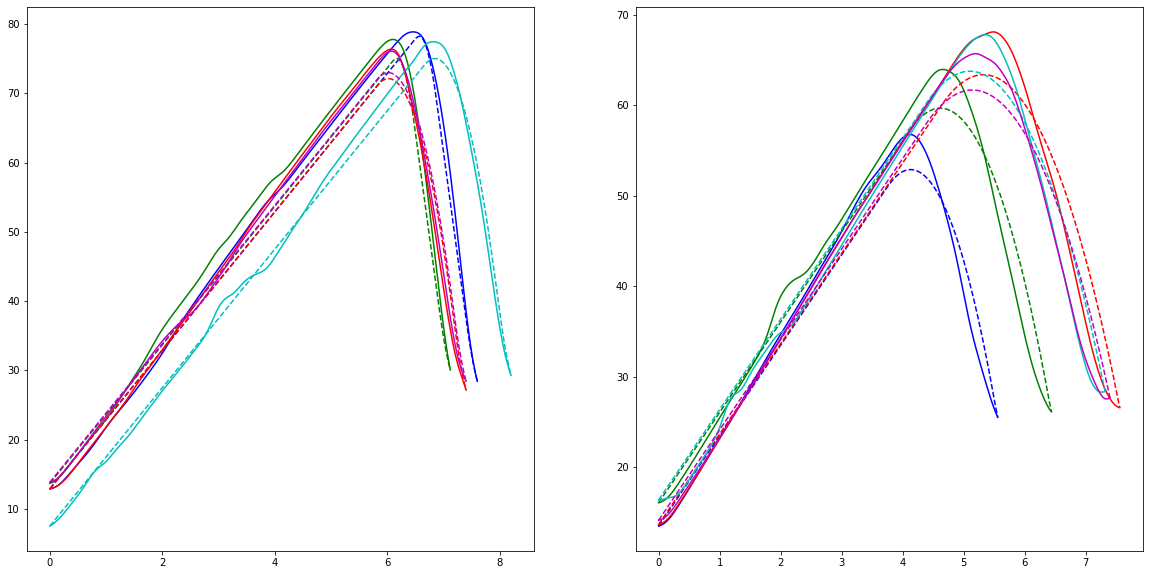

In [29]:
trajectories_before[rat][i_sess][int(shift_time/dt):]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
import matplotlib.pyplot as plt
fig = plt.figure(constrained_layout = False, figsize=(20, 10))
gs = fig.add_gridspec(1, 2) #row ,col
index = 0
#for index, rat in enumerate(selected_rats):
for rat in ['Rat302']:
    for i_sess in range(len(trajectories_before[rat])):
        ax00 = fig.add_subplot(gs[index, 0])
        ax00.plot([i*0.04 for i in range(0, len(np.array(trajectories_before[rat][i_sess][int(shift_time/dt):])))], trajectories_before[rat][i_sess][int(shift_time/dt):], color = colors[i_sess])
        ax00.plot([i*0.04 for i in range(0, len(np.array(xk_fit_before_dict[rat][i_sess])))], [i*100 for i in np.array(xk_fit_before_dict[rat][i_sess])], '--', color = colors[i_sess])

        ax0 = fig.add_subplot(gs[index, 1])
        ax0.plot([i*0.04 for i in range(0, len(np.array(trajectories_final[rat][i_sess][int(shift_time/dt):])))], trajectories_final[rat][i_sess][int(shift_time/dt):], color = colors[i_sess])
        ax0.plot([i*0.04 for i in range(0, len(np.array(xk_fit_final_dict[rat][i_sess])))], [i*100 for i in np.array(xk_fit_final_dict[rat][i_sess])], '--', color = colors[i_sess])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same argument

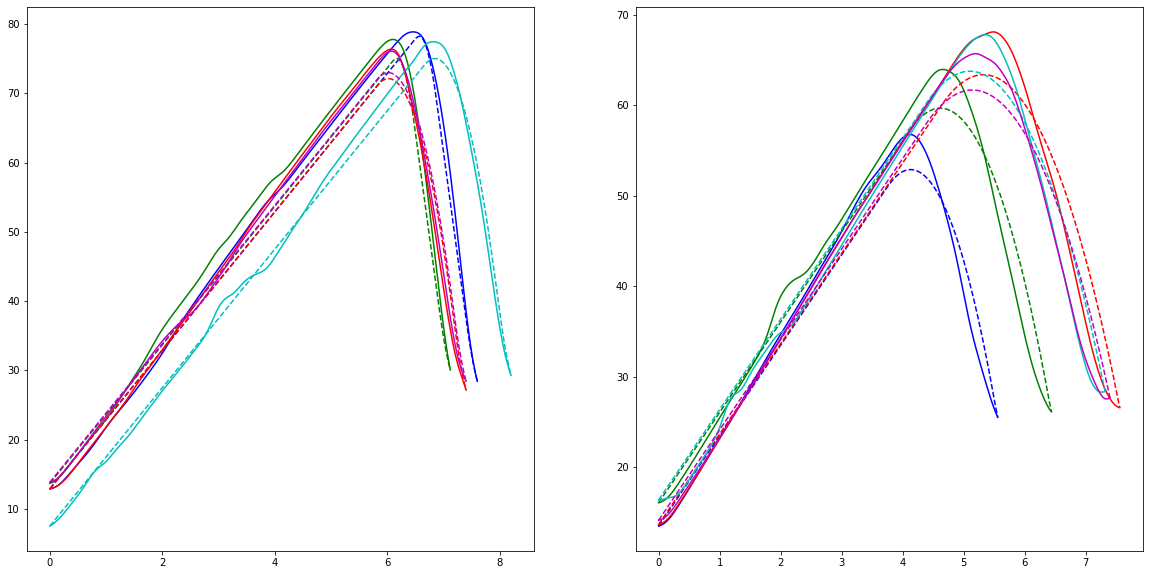

In [25]:
trajectories_before[rat][i_sess][int(shift_time/dt):]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
import matplotlib.pyplot as plt
fig = plt.figure(constrained_layout = False, figsize=(20, 10))
gs = fig.add_gridspec(1, 2) #row ,col
index = 0
#for index, rat in enumerate(selected_rats):
for rat in ['Rat302']:
    for i_sess in range(len(trajectories_before[rat])):
        ax00 = fig.add_subplot(gs[index, 0])
        ax00.plot([i*0.04 for i in range(0, len(np.array(trajectories_before[rat][i_sess][int(shift_time/dt):])))], trajectories_before[rat][i_sess][int(shift_time/dt):], color = colors[i_sess])
        ax00.plot([i*0.04 for i in range(0, len(np.array(xk_fit_before_dict[rat][i_sess])))], [i*100 for i in np.array(xk_fit_before_dict[rat][i_sess])], '--', color = colors[i_sess])

        ax0 = fig.add_subplot(gs[index, 1])
        ax0.plot([i*0.04 for i in range(0, len(np.array(trajectories_final[rat][i_sess][int(shift_time/dt):])))], trajectories_final[rat][i_sess][int(shift_time/dt):], color = colors[i_sess])
        ax0.plot([i*0.04 for i in range(0, len(np.array(xk_fit_final_dict[rat][i_sess])))], [i*100 for i in np.array(xk_fit_final_dict[rat][i_sess])], '--', color = colors[i_sess])

In [23]:
print(a_fit_before_dict)
print(a_fit_final_dict)

{'Rat302': [0.3279270802301553, 0.06035393065549477, 1.3811376319099373, 1.2645519128670144, 1.3980103154977195]}
{'Rat302': [2.952468284181248, 3.800644541443261, 5.130927707113758, 5.2440840463066465, 5.711591730202074]}


In [30]:
print(a_fit_before_dict)
print(a_fit_final_dict)

{'Rat302': [0.3279270802301553, 0.06035393065549477, 1.3811376319099373, 1.2645519128670144, 1.3980103154977195]}
{'Rat302': [2.952468284181248, 3.800644541443261, 5.130927707113758, 5.2440840463066465, 5.711591730202074]}
